# This demonstrates how to do a spatial simulation with a susceptible, resistant, and producer strains, all using toy metabolic models, in COMETS.

In [79]:
import cometspy as c
import cobra
import random
from cobra import Metabolite, Reaction, Model
import pandas as pd
import os
os.environ['GUROBI_COMETS_HOME'] = '/opt/gurobi900/linux64'
pd.set_option('display.max_rows', None) 

# Build the toy models. I'm putting the function I use here for visibility, although usually I keep it in a separate file which I import.

In [28]:
def make_RPS_cobra_models_biomass_cost(growth_rate = 1., toxin_cost = 0.02, resistance_cost = 0.0, toxin_prod = 1.):
    # this is different from make RPS cobra models because the toxin and resistance cost is put into the
    # biomass reaction, rather than a separate reaction. this is important because toxins will only
    # be created during growth.also, no need to multiply costs by growth rate. in all cases, they
    # vary directly with growth rate. finally, in all cases as much toxin is produced as carbon is taken
    # up, regardless of growth rate.
    #
    # These toy models use "carbon_c" to grow--that is the only resource
    #
    # the toxin is called "toxin_e"
    '''
    @toxin_prod:  a multiplier.  the multiple of mmol of toxin made per gram of carbon taken up
    '''
    carbon_e = Metabolite(id = "carbon_e",
               compartment = "e")
    carbon_c = Metabolite(id = "carbon_c",
                   compartment = "c")
    EX_carbon_e = Reaction(id = "EX_carbon_e",
                      lower_bound = -growth_rate, # growth rate
                      upper_bound = 1000.)
    EX_carbon_e.add_metabolites({carbon_e: -1})
    carbon_transfer = Reaction(id = "carbon_transfer",
                          lower_bound = 0.,
                          upper_bound = 1000.)
    carbon_transfer.add_metabolites({carbon_e: -1,
                                carbon_c: 1})
    Biomass = Reaction(id = "Biomass",
                  lower_bound = 0.,
                  upper_bound = 1000.)
    Biomass.add_metabolites({carbon_c: -1.})
    # make the toxicity-related metabolites and reactions
    toxin_c = Metabolite(id = "toxin_c", compartment = "c")
    toxin_e = Metabolite(id = "toxin_e", compartment = "e")

    EX_toxin_e = Reaction(id = "EX_toxin_e",
                         lower_bound = -1000.,
                         upper_bound = 1000.)
    EX_toxin_e.add_metabolites({toxin_e: -1})

    toxin_transfer = Reaction(id = "toxin_transfer",
                             lower_bound = -1000.,
                             upper_bound = 0.)
    toxin_transfer.add_metabolites({toxin_e: -1,
                                   toxin_c: 1})

    Biomass_producer = Reaction(id = "Biomass",
                  lower_bound = 0.,
                  upper_bound = 1000.)
    Biomass_producer.add_metabolites({carbon_c: -(1. + toxin_cost + resistance_cost),
                                     toxin_c: toxin_prod * (1. + toxin_cost + resistance_cost)})

    Biomass_resistant = Reaction(id = "Biomass",
                  lower_bound = 0.,
                  upper_bound = 1000.)
    Biomass_resistant.add_metabolites({carbon_c: -(1. + resistance_cost)})

    producer = Model("producer")
    producer.add_reactions([EX_carbon_e, carbon_transfer, Biomass_producer,
                        EX_toxin_e, toxin_transfer])
    producer.objective = Biomass_producer

    resistant = Model("resistant")
    resistant.add_reactions([EX_carbon_e, carbon_transfer, Biomass_resistant])
    resistant.objective = Biomass_resistant

    susceptible = Model("susceptible")
    susceptible.add_reactions([EX_carbon_e, carbon_transfer, Biomass,
                        EX_toxin_e])
    susceptible.objective = Biomass
    return((producer, resistant, susceptible))

In [37]:
growth_rate = 0.75

producer, resistant, susceptible = make_RPS_cobra_models_biomass_cost(growth_rate = growth_rate, toxin_cost = 0.02)

In [38]:
producer.summary()

In [39]:
susceptible.summary()

In [40]:
resistant.summary()

# Now make the COMETS models from these, and add a signal to the susceptible which linearly reduces growth rate until the toxin concentration = 1M, when the growth ceases altogether.

In [41]:
P = c.model(producer)
R = c.model(resistant)
S = c.model(susceptible)

P.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"
R.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"
S.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"


# Note that comets erroneously assumes the biomass equation is an exchange in the susceptible and resistant, because it is unbalanced. So we fix that first

In [42]:
S.reactions

,REACTION_NAMES,ID,LB,UB,EXCH,EXCH_IND,V_MAX,KM,HILL
0,EX_carbon_e,1,-0.75,1000.0,True,1,NaN,NaN,NaN
1,carbon_transfer,2,0.00,1000.0,False,0,NaN,NaN,NaN
2,Biomass,3,0.00,1000.0,True,2,NaN,NaN,NaN
3,EX_toxin_e,4,-1000.00,1000.0,True,3,NaN,NaN,NaN


In [43]:
R.reactions.loc[R.reactions.REACTION_NAMES == "Biomass", "EXCH"] = False
index = R.reactions.loc[R.reactions.REACTION_NAMES == "Biomass", "EXCH_IND"].values[0]
R.reactions.loc[R.reactions.REACTION_NAMES == "Biomass", "EXCH_IND"] = 0
R.reactions.loc[R.reactions.EXCH_IND > index, "EXCH_IND"] -= 1

S.reactions.loc[S.reactions.REACTION_NAMES == "Biomass", "EXCH"] = False
index = S.reactions.loc[S.reactions.REACTION_NAMES == "Biomass", "EXCH_IND"].values[0]
S.reactions.loc[S.reactions.REACTION_NAMES == "Biomass", "EXCH_IND"] = 0
S.reactions.loc[S.reactions.EXCH_IND > index, "EXCH_IND"] -= 1

In [44]:
S.reactions

,REACTION_NAMES,ID,LB,UB,EXCH,EXCH_IND,V_MAX,KM,HILL
0,EX_carbon_e,1,-0.75,1000.0,True,1,NaN,NaN,NaN
1,carbon_transfer,2,0.00,1000.0,False,0,NaN,NaN,NaN
2,Biomass,3,0.00,1000.0,False,0,NaN,NaN,NaN
3,EX_toxin_e,4,-1000.00,1000.0,True,2,NaN,NaN,NaN


# Now we add the "signal" to susceptible, which reduces growth rate proportionate to [toxin_e]. We use a "bounded_linear" function for this, because we don't want the upper bound of growth rate to go negative. 

In [49]:
biomass_id = S.reactions.loc[S.reactions.REACTION_NAMES == "Biomass", "ID"].values[0]
toxin_exch_id = S.reactions.loc[S.reactions.REACTION_NAMES == "EX_toxin_e", "EXCH_IND"].values[0]

In [52]:
gr_absense_of_toxin = growth_rate
toxin_conc_where_effect_starts = 0.
slope_of_toxin_effect = -growth_rate
toxin_conc_where_effect_saturates = 1.
S.add_signal(biomass_id, toxin_exch_id, 'ub', 'bounded_linear', 
             parms = [gr_absense_of_toxin, 
                      toxin_conc_where_effect_starts, 
                      slope_of_toxin_effect,
                     toxin_conc_where_effect_saturates])
S.signals

,REACTION_NUMBER,EXCH_IND,BOUND,FUNCTION,PARAMETERS,REACTION_NAMES,EXCH
0,3,2,ub,bounded_linear,"[0.75, 0.0, -0.75, 1.0]",Biomass,toxin_e
1,3,2,ub,bounded_linear,"[0.75, 0.0, -0.75, 1.0]",Biomass,toxin_e


# First lets do a well-mixed simulation.

In [70]:
S.initial_pop = [0, 0, 1.e-10]
R.initial_pop = [0, 0, 1.e-10]
P.initial_pop = [0, 0, 1.e-10]

l = c.layout([P, R, S])
l.set_specific_metabolite("carbon_e", 4.e-7)

p = c.params()
p.set_param("defaultVmax", 1.)
p.set_param("defaultKm", 0.000001) 
p.set_param('maxCycles', 300)
p.set_param('timeStep', 0.1)
p.set_param('spaceWidth', 0.02) # i.e. 2cm x 2cm
p.set_param('writeMediaLog', True)
p.set_param('MediaLogRate', 1)
p.set_param('writeFluxLog', True)
p.set_param('FluxLogRate', 1)
p.set_param("totalBiomassLogRate", 1)

sim = c.comets(l, p)
sim.VERSION = 'comets_multitoxin.jar'
sim.set_classpath('bin', '/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_multitoxin.jar')
sim.run()


Running COMETS simulation ...
Done!


# Notice that susceptible ends up lower than resistant, but higher than producer. This all makes sense: producer has a cost of making the toxin (2% growth rate), resistant has no cost, and susceptible slowly decreases in growth rate.

<AxesSubplot:xlabel='cycle'>

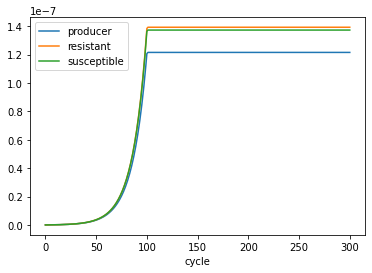

In [71]:
sim.total_biomass.plot(x = "cycle")

(0.7, 0.8)

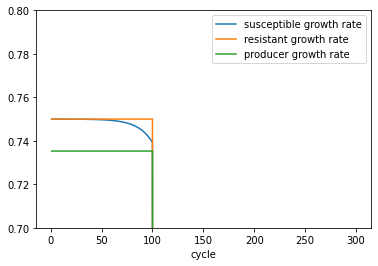

In [72]:
ax = sim.fluxes_by_species["susceptible"].plot(x = "cycle", y = "Biomass", label = "susceptible growth rate")
sim.fluxes_by_species["resistant"].plot(x = "cycle", y = "Biomass", 
                                        ax = ax, label = "resistant growth rate")
sim.fluxes_by_species["producer"].plot(x = "cycle", y = "Biomass", 
                                        ax = ax, label = "producer growth rate")
ax.set_ylim(0.7,0.8)

# the things which will affect "who wins" in these sims are the toxin cost, the toxin production rate (by default it is 1mmol toxin / gram growth), the total amount of carbon, the initial pop, and the spacewidth. Spacewidth is true even in well-mixed because it influences the concentration of the toxin (mmol / spaceWidth^3)--it is in fact a critical value.


Running COMETS simulation ...
Done!


(0.7, 0.8)

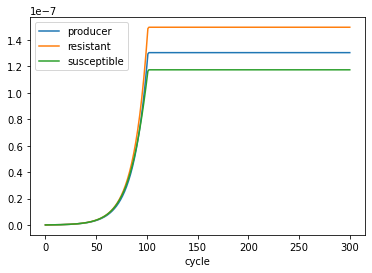

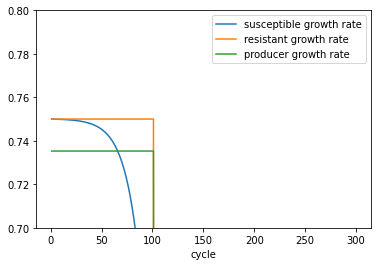

In [77]:
S.initial_pop = [0, 0, 1.e-10]
R.initial_pop = [0, 0, 1.e-10]
P.initial_pop = [0, 0, 1.e-10]

l = c.layout([P, R, S])
l.set_specific_metabolite("carbon_e", 4.e-7)

p = c.params()
p.set_param("defaultVmax", 1.)
p.set_param("defaultKm", 0.000001) 
p.set_param('maxCycles', 300)
p.set_param('timeStep', 0.1)
p.set_param('spaceWidth', 0.008) # smaller!
p.set_param('writeMediaLog', True)
p.set_param('MediaLogRate', 1)
p.set_param('writeFluxLog', True)
p.set_param('FluxLogRate', 1)
p.set_param("totalBiomassLogRate", 1)

sim = c.comets(l, p)
sim.VERSION = 'comets_multitoxin.jar'
sim.set_classpath('bin', '/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_multitoxin.jar')
sim.run()

# Plotting
sim.total_biomass.plot(x = "cycle")

ax = sim.fluxes_by_species["susceptible"].plot(x = "cycle", y = "Biomass", label = "susceptible growth rate")
sim.fluxes_by_species["resistant"].plot(x = "cycle", y = "Biomass", 
                                        ax = ax, label = "resistant growth rate")
sim.fluxes_by_species["producer"].plot(x = "cycle", y = "Biomass", 
                                        ax = ax, label = "producer growth rate")
ax.set_ylim(0.7,0.8)

# Now do it in a spatial world. Basically the same as we've done before. I'm doing a quick random locs func that is a bit simpler from that in cometspy.util.

The deterministic simulations had 1 producer, 1 resistant, and 4 susceptibles. Let's have 30 founder colonies and use this ratio. 

In [85]:
def pick_unique_locations(width, height, n, edge_space = 0):
    locs = []
    while len(locs) < n:
        loc = (random.randrange(edge_space, width - edge_space),
               random.randrange(edge_space, height - edge_space))
        if loc not in locs:
            locs.append(loc)
    return(locs)

grid_size =[30, 30] # this was 100x100 in the actual sims!

locs = pick_unique_locations(grid_size[0], grid_size[1], 30, 3)
producer_locs = locs[0:5]
resistant_locs = locs[5:10]
susceptible_locs = locs[10:]

## If you want to save the initial locations (useful for doing spatially-explicit analyses later), here's one approach

In [86]:
spatial_data = pd.DataFrame(columns = ["strain", "x", "y"])
producer_data = pd.DataFrame({"strain" : "producer",
                             "x" : [x[0] for x in producer_locs],
                             "y" : [x[1] for x in producer_locs]})
resistant_data = pd.DataFrame({"strain" : "resistant",
                             "x" : [x[0] for x in resistant_locs],
                             "y" : [x[1] for x in resistant_locs]})
susceptible_data = pd.DataFrame({"strain" : "susceptible",
                             "x" : [x[0] for x in susceptible_locs],
                             "y" : [x[1] for x in susceptible_locs]})
spatial_data = spatial_data.append(producer_data, 
                                   ignore_index = True).append(resistant_data, 
                                                               ignore_index = True).append(susceptible_data, ignore_index = True)
# spatial_data.to_csv("whatever_you_want_to_call_the_file.csv")
spatial_data.head(11)

,strain,x,y
0,producer,19,8
1,producer,9,22
2,producer,24,3
3,producer,10,20
4,producer,18,17
5,resistant,11,19
6,resistant,26,15
7,resistant,7,23
8,resistant,9,21
9,resistant,23,9


Note that the timeStep must be pretty small. Note also that we set the toxin_e diffusion constant to 10x lower than the defaultDiffConst. 

Also, I set the maxCycles to 5, because when doing spatial sims its good to check the run_output to make sure our timeStep was small enough

In [130]:
initial_biomass = 1.e-10
S.initial_pop = [[loc[0], loc[1], initial_biomass] for loc in susceptible_locs]
P.initial_pop = [[loc[0], loc[1], initial_biomass] for loc in producer_locs]
R.initial_pop = [[loc[0], loc[1], initial_biomass] for loc in resistant_locs]

l = c.layout([P, R, S])
l.grid = grid_size
l.set_specific_metabolite("carbon_e", 4.e-7)
l.media.loc[l.media.metabolite == "toxin_e", "diff_c"] = 5.e-7

p = c.params()
p.set_param("defaultVmax", 1.)
p.set_param("defaultKm", 0.000001) 
p.set_param('maxCycles', 5) #  60*24)
p.set_param('timeStep', 1/60) # 1 minute
p.set_param('spaceWidth', 0.0025) # smaller!
p.set_param("defaultDiffConst", 5.e-6)
p.set_param('minSpaceBiomass', 1.e-15)
p.set_param('writeMediaLog', True)
p.set_param('MediaLogRate', 1)
p.set_param('writeFluxLog', True)
p.set_param('FluxLogRate', 1)
p.set_param("totalBiomassLogRate", 1)
p.set_param("numDiffPerStep", 1)

sim = c.comets(l, p)
sim.VERSION = 'comets_multitoxin.jar'
sim.set_classpath('bin', '/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_multitoxin.jar')
sim.run()


Running COMETS simulation ...
Done!


In [131]:
print(sim.run_output)

-script
running script file: /home/jeremy/Dropbox/work_related/harcombe_lab/comets_protocols/growth_rate_vs_toxins/.current_script_0x7f43a79efc50
Current Java version: 11.0.17
Parameters file .current_global_0x7f43a79efc50 loaded.
Parameters file .current_package_0x7f43a79efc50 loaded.
Loading layout file '.current_layout_0x7f43a79efc50'...
null/COMETS_manifest.txt (No such file or directory)
Unable to initialize manifest file. 
Continuing without writing manifest file.
Found 3 model files!
Loading './producer.cmd' ...
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Done!
 Testing default parameters...
Done!
Optimizer status code = 5 (looks ok!)
objective solution = 0.7352941176470588
Loading './resistant.cmd' ...
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Done!
 Testing default parameters...
Done!
Optimizer status code = 5 (looks ok!)
objective solution = 0.75
Loading './susceptible.cmd' .

OK, lets increase numDiffPerStep

In [133]:
p.set_param("numDiffPerStep", 60)
sim = c.comets(l, p)
sim.VERSION = 'comets_multitoxin.jar'
sim.set_classpath('bin', '/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_multitoxin.jar')
sim.run()
print(sim.run_output)


Running COMETS simulation ...
Done!
-script
running script file: /home/jeremy/Dropbox/work_related/harcombe_lab/comets_protocols/growth_rate_vs_toxins/.current_script_0x7f43a725a198
Current Java version: 11.0.17
Parameters file .current_global_0x7f43a725a198 loaded.
Parameters file .current_package_0x7f43a725a198 loaded.
Loading layout file '.current_layout_0x7f43a725a198'...
null/COMETS_manifest.txt (No such file or directory)
Unable to initialize manifest file. 
Continuing without writing manifest file.
Found 3 model files!
Loading './producer.cmd' ...
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Done!
 Testing default parameters...
Done!
Optimizer status code = 5 (looks ok!)
objective solution = 0.7352941176470588
Loading './resistant.cmd' ...
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Done!
 Testing default parameters...
Done!
Optimizer status code = 5 (looks ok!)
objective solution

# okay looks good, no warning about diffusion constants. Increase maxCycles and move forward

In [135]:
p.set_param("maxCycles", 60 * 36)
sim = c.comets(l, p)
sim.VERSION = 'comets_multitoxin.jar'
sim.set_classpath('bin', '/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_multitoxin.jar')
sim.run()



Running COMETS simulation ...
Done!


<AxesSubplot:xlabel='cycle'>

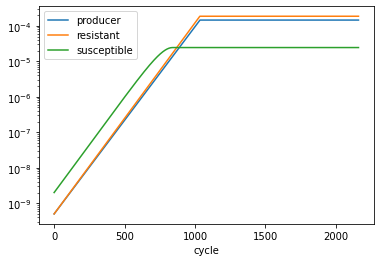

In [136]:
sim.total_biomass.plot(x = "cycle", logy = True)